# Load package

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline 

# Load data

In [3]:
path = '../data/'
trip_2013 = pd.read_csv(path + 'FOIL2013/trip_data_6.csv')
trip_2013.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2013009441,2013013593,VTS,1,NaN,2013-06-01 00:00:00,2013-06-01 00:05:00,1,300,0.74,-73.972008,40.749767,-73.968109,40.756382
1,2013012081,2013019632,VTS,1,NaN,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.52,-73.984909,40.779106,-73.944702,40.803219
2,2013006133,2013029678,VTS,1,NaN,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992
3,2013007864,2013007860,VTS,1,NaN,2013-06-01 00:00:00,2013-06-01 00:08:00,1,480,1.63,-73.982071,40.743259,-73.990967,40.723995
4,2013010123,2013010123,VTS,1,NaN,2013-06-01 00:00:00,2013-06-01 00:19:00,4,1140,5.98,-73.999809,40.732849,-73.962357,40.800049


In [4]:
def clean_time(data):
    '''
    Convert pick-up and drop-off datetime from string to datetime
    '''
    data.loc[:,'pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data.loc[:,'dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])
    return data 

In [5]:
# Remove spaces in column names, and covert to lower cases
trip_2013.columns = trip_2013.columns.str.replace(' ','').str.lower()
trip_2013 = trip_2013.loc[:,['hack_license','pickup_datetime','dropoff_datetime']]
trip_2013 = clean_time(trip_2013)

In [6]:
trip_2013.head()

,hack_license,pickup_datetime,dropoff_datetime
0,2013013593,2013-06-01,2013-06-01 00:05:00
1,2013019632,2013-06-01,2013-06-01 00:16:00
2,2013029678,2013-06-01,2013-06-01 00:10:00
3,2013007860,2013-06-01,2013-06-01 00:08:00
4,2013010123,2013-06-01,2013-06-01 00:19:00


In [7]:
# to fit into memory
## get info from sat 1/5/13 - fri 1/11/13
trip_2013 = trip_2013[datetime.datetime.strptime('2013-06-10','%Y-%m-%d') <= trip_2013['pickup_datetime']]
trip_2013 = trip_2013[trip_2013['pickup_datetime'] < datetime.datetime.strptime('2013-06-17','%Y-%m-%d')]
trip_2013 = trip_2013.astype({'hack_license': 'int32'})
trip_2013.head()

,hack_license,pickup_datetime,dropoff_datetime
4391103,2013009991,2013-06-10,2013-06-10 00:25:00
4391104,2013035947,2013-06-10,2013-06-10 00:11:00
4391105,2013032410,2013-06-10,2013-06-10 00:11:00
4391106,2013012548,2013-06-10,2013-06-10 00:13:00
4391107,2013014844,2013-06-10,2013-06-10 00:20:00


In [8]:
trip_2013.shape

(3366734, 3)

In [9]:
# calculate delta = next trip pickup time - current trip dropoff time
trip_2013 = trip_2013.merge(trip_2013, on='hack_license', suffixes=['_now','_next'])
# find all the future trips whose pickup time > current trip dropoff time
trip_2013 = trip_2013[trip_2013['dropoff_datetime_now'] <= trip_2013['pickup_datetime_next']]
# find the next trip
trip_2013 = trip_2013.groupby(['hack_license',
                               'pickup_datetime_now',
                               'dropoff_datetime_now'])['pickup_datetime_next'].min().reset_index()
# calculate delta
trip_2013['delta'] = (trip_2013['pickup_datetime_next'] - trip_2013['dropoff_datetime_now']) / pd.Timedelta(hours=1)
trip_2013.head()

,hack_license,pickup_datetime_now,dropoff_datetime_now,pickup_datetime_next,delta
0,2013000002,2013-06-12 17:43:27,2013-06-12 18:12:15,2013-06-12 18:14:10,0.031944
1,2013000002,2013-06-12 18:14:10,2013-06-12 18:47:34,2013-06-12 19:09:34,0.366667
2,2013000002,2013-06-12 19:09:34,2013-06-12 19:47:34,2013-06-12 19:49:53,0.038611
3,2013000002,2013-06-12 19:49:53,2013-06-12 20:18:24,2013-06-12 20:24:41,0.104722
4,2013000002,2013-06-12 20:24:41,2013-06-12 20:58:34,2013-06-12 21:05:21,0.113056


In [10]:
# calculate the start and end working time of drivers
# if delta > k hours, dropoff time = end working time, next trip's pickup time = start working time
k = 5
pick_drop = trip_2013[trip_2013.delta > k]
# find the end working time of next shift; working hours = end working time - start working time
pick_drop = pick_drop.merge(pick_drop[['hack_license','dropoff_datetime_now']], on='hack_license', suffixes=[None,'_end'])
# find all the futre trips whose dropoff time < start working time
pick_drop = pick_drop[pick_drop['pickup_datetime_next'] <= pick_drop['dropoff_datetime_now_end']]
# find the last trip of a shift
pick_drop = pick_drop.groupby(['hack_license',
                               'dropoff_datetime_now','pickup_datetime_next',
                               'delta']).dropoff_datetime_now_end.min().reset_index()
# calculate working hours
pick_drop['work_hour'] = (pick_drop['dropoff_datetime_now_end'] - pick_drop['pickup_datetime_next']) / pd.Timedelta(hours=1)
pick_drop.head()

,hack_license,dropoff_datetime_now,pickup_datetime_next,delta,dropoff_datetime_now_end,work_hour
0,2013000002,2013-06-13 01:30:59,2013-06-13 16:55:04,15.401389,2013-06-14 01:56:03,9.016389
1,2013000002,2013-06-14 01:56:03,2013-06-14 18:24:53,16.480556,2013-06-15 04:09:57,9.751111
2,2013000002,2013-06-15 04:09:57,2013-06-15 18:51:24,14.690833,2013-06-16 05:46:09,10.912500
3,2013000003,2013-06-10 03:30:00,2013-06-10 16:08:00,12.633333,2013-06-11 04:41:00,12.550000
4,2013000003,2013-06-11 04:41:00,2013-06-12 17:53:00,37.200000,2013-06-13 05:06:00,11.216667


In [11]:
# extract hour, date, weekday(boolean) from datetime columns
pick_drop['dropoff_hour_now'] = pick_drop.dropoff_datetime_now.dt.hour
pick_drop['pickup_hour_next'] = pick_drop.pickup_datetime_next.dt.hour
pick_drop['dropoff_day_now'] = pick_drop.dropoff_datetime_now.dt.date
pick_drop['pickup_day_next'] = pick_drop.pickup_datetime_next.dt.date
pick_drop['weekday'] = (pick_drop.loc[:,'dropoff_datetime_now'].dt.dayofweek // 5 == 1).astype(int)
pick_drop.head()

,hack_license,dropoff_datetime_now,pickup_datetime_next,delta,dropoff_datetime_now_end,work_hour,dropoff_hour_now,pickup_hour_next,dropoff_day_now,pickup_day_next,weekday
0,2013000002,2013-06-13 01:30:59,2013-06-13 16:55:04,15.401389,2013-06-14 01:56:03,9.016389,1,16,2013-06-13,2013-06-13,0
1,2013000002,2013-06-14 01:56:03,2013-06-14 18:24:53,16.480556,2013-06-15 04:09:57,9.751111,1,18,2013-06-14,2013-06-14,0
2,2013000002,2013-06-15 04:09:57,2013-06-15 18:51:24,14.690833,2013-06-16 05:46:09,10.912500,4,18,2013-06-15,2013-06-15,1
3,2013000003,2013-06-10 03:30:00,2013-06-10 16:08:00,12.633333,2013-06-11 04:41:00,12.550000,3,16,2013-06-10,2013-06-10,0
4,2013000003,2013-06-11 04:41:00,2013-06-12 17:53:00,37.200000,2013-06-13 05:06:00,11.216667,4,17,2013-06-11,2013-06-12,0


In [16]:
# calculate percentage of pickup and dropoff in each hour, averaged across date
pickup_per = pick_drop.groupby(['pickup_day_next','weekday','pickup_hour_next'])['pickup_hour_next'].count()
# percentage = # pickup in each hour / # pickup in the day
pickup_per = pickup_per.groupby(level=0).apply(lambda x: x / x.sum() * 100) 
pickup_per = pd.DataFrame(pickup_per).rename(columns={'pickup_hour_next':'pickup_percent'}).reset_index().\
                                        rename(columns={'pickup_day_next':'date',
                                                        'pickup_hour_next':'hour'})

dropoff_per = pick_drop.groupby(['dropoff_day_now','weekday','dropoff_hour_now'])['dropoff_hour_now'].count()
dropoff_per = dropoff_per.groupby(level=0).apply(lambda x: x / x.sum() * 100) 
dropoff_per = pd.DataFrame(dropoff_per).rename(columns={'dropoff_hour_now':'dropoff_percent'}).reset_index().\
                                        rename(columns={'dropoff_day_now':'date',
                                                        'dropoff_hour_now':'hour'})
pick_drop_per = pickup_per.merge(dropoff_per)
pick_drop_per.head()

,date,weekday,hour,pickup_percent,dropoff_percent
0,2013-06-10,0,5,0.122249,1.626678
1,2013-06-10,0,6,0.513447,0.538837
2,2013-06-10,0,7,0.611247,0.350752
3,2013-06-10,0,8,0.660147,0.299919
4,2013-06-10,0,9,0.537897,0.610004


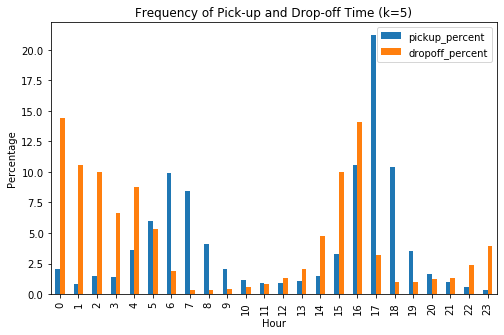

In [17]:
# Frequency of Pick-up and Drop-off Time
pick_drop_per_all = pick_drop_per.groupby(['hour'])['pickup_percent','dropoff_percent'].mean().\
                                reset_index().set_index('hour')

fig,ax = plt.subplots(figsize = (8,5))
pick_drop_per_all.plot(kind='bar',ax=ax);
ax.set_xlabel('Hour');
ax.set_ylabel('Percentage');
ax.set_title('Frequency of Pick-up and Drop-off Time (k={})'.format(k));
ax.legend();

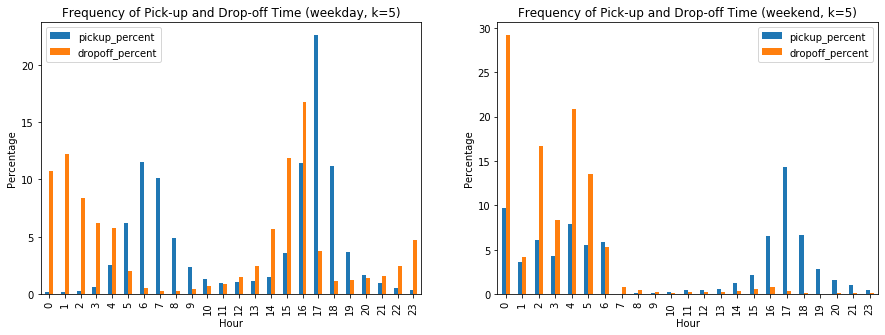

In [20]:
# Frequency of Pick-up and Drop-off Time (weekday and weekend)
pick_drop_per_wk = pick_drop_per.groupby(['hour','weekday'])['pickup_percent','dropoff_percent'].mean().\
                                reset_index().set_index('hour')

fig,ax = plt.subplots(1,2,figsize = (15,5))
pick_drop_per_wk[pick_drop_per_wk.weekday == 0].drop('weekday',axis=1).plot(kind='bar',ax=ax[0]);
pick_drop_per_wk[pick_drop_per_wk.weekday == 1].drop('weekday',axis=1).plot(kind='bar',ax=ax[1]);
ax[0].set_xlabel('Hour');
ax[0].set_ylabel('Percentage');
ax[0].set_title('Frequency of Pick-up and Drop-off Time (weekday, k={})'.format(k));
ax[0].legend();

ax[1].set_xlabel('Hour');
ax[1].set_ylabel('Percentage');
ax[1].set_title('Frequency of Pick-up and Drop-off Time (weekend, k={})'.format(k));
ax[1].legend();

In [38]:
# plt.boxplot(pick_drop.work_hour);
n = pick_drop[pick_drop.work_hour>=24].shape[0] / pick_drop.shape[0] * 100
print('drop {n:.2f}% records'.format(n=n))
pick_drop = pick_drop[pick_drop.work_hour<24]

drop 0.50% records


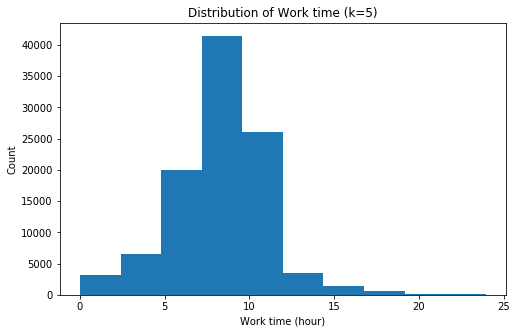

In [39]:
fig,ax = plt.subplots(figsize = (8,5))
ax.hist(pick_drop.loc[:,'work_hour']);
ax.set_xlabel('Work time (hour)');
ax.set_ylabel('Count');
ax.set_title('Distribution of Work time (k={})'.format(k));

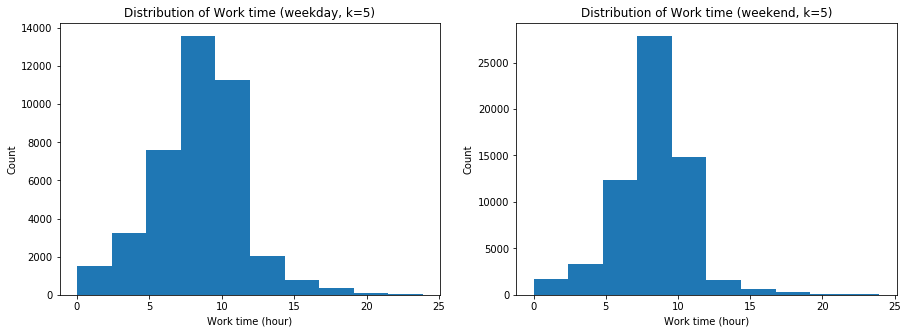

In [40]:
fig,ax = plt.subplots(1,2,figsize = (15,5))
ax[0].hist(pick_drop.loc[pick_drop.weekday == 1,'work_hour']);
ax[1].hist(pick_drop.loc[pick_drop.weekday == 0,'work_hour']);
ax[0].set_xlabel('Work time (hour)');
ax[0].set_ylabel('Count');
ax[0].set_title('Distribution of Work time (weekday, k={})'.format(k));
ax[1].set_xlabel('Work time (hour)');
ax[1].set_ylabel('Count');
ax[1].set_title('Distribution of Work time (weekend, k={})'.format(k));